# Word Representation
1.   **Algorithm** (Word2Vec, Doc2Vec)
2.   **Library** (gensim, sklearn)
3.   **Result** (Finding the most similar text for documents & most similar words with Word2Vec & Doc2Vec models)

Install and upgrade required library

In [ ]:
!pip install --upgrade gensim
!pip install arabic_reshaper
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
import math
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

Downlaod data

In [ ]:
!gdown --id 1rovazK48q7pHcEM271aX70Dr594NYQ77
!gdown --id 1ZCHuj6JtyOkb5ismn3qF3Rp2DRGJ1tRk

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rovazK48q7pHcEM271aX70Dr594NYQ77
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 21.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZCHuj6JtyOkb5ismn3qF3Rp2DRGJ1tRk
To: /content/test.csv
100% 2.03M/2.03M [00:00<00:00, 15.6MB/s]


Preprocess

In [ ]:
# read dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# this function removes the punctuation marks and non-alphabetic words from given document
# and returns an array of document words
def clean_text(doc):

  tokens = doc.split()
  translation_table = str.maketrans('', '', "><.،؟؛:{}\|+ـ()*&^٪$#❊!/[]=-")
  tokens = [word.translate(translation_table) for word in tokens]
  tokens = [word for word in tokens if word.isalpha()]

  return tokens

**Q 1:**

> Train **Word2Vec** model(Skip-gram) & **Doc2Vec** model



In [ ]:
# prepare input for gensim word2vec model

train_words = []
for index, row in train.iterrows():
  train_words.append([row.id, clean_text(row.article)])

In [ ]:
train_words_cleaned = [item[1] for item in train_words]

In [ ]:
print(train_words_cleaned[:5])

[['آيا', 'مشكل', 'اصلي', 'سينماي', 'ايران', 'فيلمنامه', 'است', 'اين', 'هفته', 'با', 'ميهن', 'بهرامي', 'ميهن', 'بهرامي', 'داراي', 'تحصيلات', 'تا', 'مقطع', 'دكتري', 'در', 'رشته', 'هاي', 'روان', 'شناسي', 'جامعه', 'شناسي', 'فلسفه', 'مجسمه', 'سازي', 'و', 'خوشنويسي', 'است', 'او', 'طي', 'سالها', 'در', 'كنار', 'پرداختن', 'به', 'مطالعه', 'و', 'تحقيق', 'در', 'رشته', 'هاي', 'تخصصي', 'اش', 'در', 'عرصه', 'نگارش', 'فيلمنامه', 'مقاله', 'و', 'كتاب', 'و', 'همچنين', 'نقد', 'و', 'بررسي', 'فيلم', 'هاي', 'سينمايي', 'فعاليتهاي', 'گسترده', 'اي', 'داشته', 'است', 'خانم', 'بهرامي', 'لطفا', 'بفرماييد', 'كه', 'به', 'نظر', 'شما', 'مشكل', 'اصلي', 'سينماي', 'ايران', 'چيست', 'و', 'آيا', 'شما', 'با', 'آن', 'عده', 'اي', 'كه', 'اين', 'مشكل', 'را', 'ناشي', 'از', 'فيلمنامه', 'مي', 'دانند', 'موافقيد', 'مشكل', 'سينماي', 'ايران', 'مشكلي', 'است', 'در', 'حد', 'يك', 'مساله', 'اجتماعي', 'مساله', 'اي', 'است', 'كه', 'مثل', 'يك', 'رشته', 'مسيرهاي', 'انحرافي', 'و', 'فصلي', 'جريان', 'ساخت', 'فيلم', 'را', 'به', 'خودش', 'مي', 'كشد', 'ا

In [ ]:
w2v_model = Word2Vec(train_words_cleaned, min_count=5, vector_size=300, window=10, sg=1)

In [ ]:
# prepare input for gensim doc2vec model
train_docs = [TaggedDocument(doc.article.split(" "), [doc.id]) for index, doc in train.iterrows()]

In [ ]:
# train doc2vec model
d2v_model = Doc2Vec(train_docs, min_count=5, vector_size=300, window=10)

**Q 2:**

> Obtain the document representation vectors for the documents in the **test corpus** using **Word2vec** & **Doc2vec** model



In [ ]:
# this function creates two term_doc, and doc_term dictionaries
def create_tf_idf_dicts(docs, DIDs):

  # [key = T (term)] --> dict[key = D (doc)] --> number of times the term T appeared in doc D
  term_doc = {}

  # [key = D (doc)] --> dict[key = T (term)] --> number of times the term T appeared in doc D
  doc_term = {}

  for doc, DID in zip(docs, DIDs):

    terms = clean_text(doc)

    doc_term[DID] = {}

    for term in terms:

  # update doc_term[DID] dictionary

      # current term has appeared in document 'DID' in orevious steps:
      if term in doc_term[DID]:
        doc_term[DID][term] += 1

      # this is the first occurrance of the current term in document 'DID':
      else:
        doc_term[DID][term] = 1

  # update term_doc[term] dictionary

      if not term in term_doc:
        term_doc[term] = {}

      # current term has appeared in document DID in previous steps:
      if DID in term_doc[term]:
          term_doc[term][DID] +=1

      # this is the first time the current term appears in document DID:
      else:
        term_doc[term][DID] = 1

  return term_doc, doc_term

In [ ]:
term_doc_train, doc_term_train = create_tf_idf_dicts(train.article, train.id)
term_doc_test, doc_term_test = create_tf_idf_dicts(test.article, test.id)

In [ ]:
# this function calculates the IDF weight of input term
def get_idf(term, doc_term, N):

  df = 0

  for doc in doc_term:
    if term in doc_term[doc]:
      df += 1

  if df > 0:
    idf = math.log((N / df), 10)

  return idf

In [ ]:
# this function calculates the TF-IDF weight of input term within the input document

def get_tf_idf(term, doc, term_doc, doc_term, doc_num):

  count_t_d = 0

  if doc in term_doc[term]:
    count_t_d = term_doc[term][doc]
    tf = 1 + math.log(count_t_d, 10)

  idf = get_idf(term, doc_term, doc_num)

  return tf * idf

In [ ]:
# prepare test data to infer vectors from word2vec and doc2vec model

test_words = []
for index, row in test.iterrows():
  test_words.append([row.id, clean_text(row.article)])

In [ ]:
# computing weighted average of w2v vectors for documents of dataset

def get_weighted_w2v_vectors(doc_words, w2v_model, term_doc, doc_term, doc_num):

  data_w2v_dic = {}

  for doc in doc_words:
    tf_idf_sum = 0
    doc_vec_sum = 0

    for word in doc[1]:
      if word in w2v_model.wv.key_to_index:
        doc_vec_sum += get_tf_idf(word, doc[0], term_doc, doc_term, doc_num) * w2v_model.wv[word]
        tf_idf_sum += get_tf_idf(word, doc[0], term_doc, doc_term, doc_num)

    data_w2v_dic[doc[0]] = doc_vec_sum / tf_idf_sum

  return data_w2v_dic

In [ ]:
N_train = len(train)
N_test = len(test)

In [23]:
# get train data word2vec vectors (weighted-average with TF-IDF)
train_w2v_dic = get_weighted_w2v_vectors(train_words, w2v_model, term_doc_train, doc_term_train, N_train)

# get test data word2vec vectors (weighted-average with TF-IDF)
test_w2v_dic = get_weighted_w2v_vectors(test_words, w2v_model, term_doc_test, doc_term_train, N_train)

In [24]:
# get doc2vec vectors for document of dataset

def get_d2v_vectors(doc_words, data_type, d2v_model):
  data_d2v_dic = {}
  for doc in doc_words:
    if data_type == 'train':
      data_d2v_dic[doc[0]] = d2v_model.dv[doc[0]]
    else:
      data_d2v_dic[doc[0]] = d2v_model.infer_vector(doc[1])
  return data_d2v_dic

In [25]:
# get train data doc2vec vectors
train_d2v_dic = get_d2v_vectors(train_words, "train", d2v_model)

# get test data doc2vec vectors
test_d2v_dic = get_d2v_vectors(test_words, "test", d2v_model)

**Q 3:**

> Find the most similar text for each of the following documents from the training set. Cosine similarity is used as the similarity measure.


1.   Doc443
2.   Doc428
3.   Doc635






In [26]:
# The ID of the documents in question.
test_doc_ids = ["Doc443", "Doc428", "Doc635"]

In [27]:
def find_most_sim_doc(train, test_doc_id, train_emb_dic, test_emb_dic):

  sims = []

  for index, row in train.iterrows():
    sims.append([row.id, row.article, cosine_similarity([train_emb_dic[row.id]], [test_emb_dic[test_doc_id]])[0][0]])

  sorted_sims = sorted(sims, key=itemgetter(2), reverse=True)

  return sorted_sims[0]


Word2Vec(weighted-average with TF-IDF)

In [28]:
# get most similar document with word2vec (weighted-average with TF-IDF)

for id in test_doc_ids:
  print("Doc Id:", id)
  print("Most similar doc:", find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[0])
  print("Cosine sim value:", find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[2])
  print()

Doc Id: Doc443
Most similar doc: Doc595
Cosine sim value: 0.9925451

Doc Id: Doc428
Most similar doc: Doc326
Cosine sim value: 0.97905797

Doc Id: Doc635
Most similar doc: Doc194
Cosine sim value: 0.99056673



Doc2Vec

In [29]:
# get most similar document with doc2vec representation

for id in test_doc_ids:
  print("Doc Id:", id)
  print("Most similar doc:", find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[0])
  print("Cosine sim value:", find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[2])
  print()

Doc Id: Doc443
Most similar doc: Doc591
Cosine sim value: 0.6378695

Doc Id: Doc428
Most similar doc: Doc303
Cosine sim value: 0.51868314

Doc Id: Doc635
Most similar doc: Doc551
Cosine sim value: 0.6393849



Question output

In [30]:
for id in test_doc_ids:
  print(id, " : ", f"(A, {find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[0]}, {find_most_sim_doc(train, id, train_w2v_dic, test_w2v_dic)[2]}),",
        f"(B, {find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[0]}, {find_most_sim_doc(train, id, train_d2v_dic, test_d2v_dic)[2]})")
  print()

Doc443  :  (A, Doc595, 0.9925451278686523), (B, Doc591, 0.6378694772720337)

Doc428  :  (A, Doc326, 0.9790579676628113), (B, Doc303, 0.518683135509491)

Doc635  :  (A, Doc194, 0.9905667304992676), (B, Doc551, 0.639384925365448)



**Q 4:**

> For each of the following words, the three most similar words have been provided from all the words extracted in the word2vec representation from the training data


1.    بهداشت
2.    استقلال
3.    رودخانه



In [31]:
selected_words = ['بهداشت', 'استقلال', 'رودخانه']

In [32]:
for word in selected_words:
  print(word, ":")
  print(w2v_model.wv.most_similar(word, topn=3))
  print()

بهداشت :
[('بهورزان', 0.7043572664260864), ('پرستاران', 0.7011229395866394), ('بهداشتي', 0.6863861083984375)]

استقلال :
[('پاس', 0.5838642120361328), ('ارضي', 0.5652087330818176), ('سپاسي', 0.5584760308265686)]

رودخانه :
[('درياچه', 0.7698966860771179), ('كارون', 0.7437077164649963), ('رودهاي', 0.7382424473762512)]



**Q 5:**

> The vector of each word from question 4, along with the ten most similar words to each of them, has been displayed in a plot


In [33]:
def get_cluster_embeddings(keys, w2v_model):

  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2v_model.wv.key_to_index:
      print('The word ', word, 'is not in the dictionary')
      continue

    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k)))
  embeddings_en_2d = embeddings_en_2d.reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

In [34]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):

  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  converted_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

  for label, embeddings, words, color in zip(converted_labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    plt.scatter(x, y, color=color, alpha=alpha, label=label)

    for i, word in enumerate(words):
      plt.annotate(get_display(arabic_reshaper.reshape(word)),
                   alpha=alpha,
                   xy=(x[i], y[i]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   ha='right',
                   va='bottom',
                   size=10)

  plt.legend(loc="lower left")
  plt.title(title)
  plt.grid(True)

  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')

  plt.show()

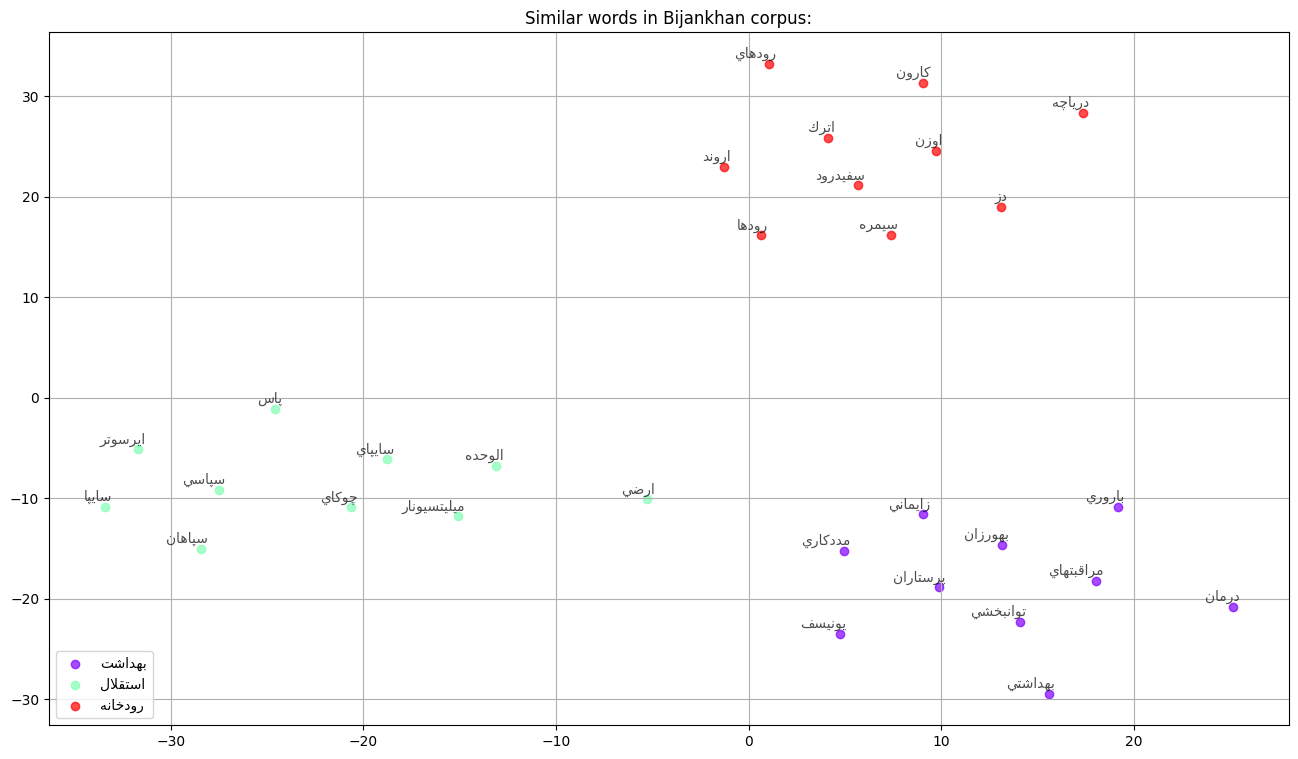

In [35]:
words = ['بهداشت', 'استقلال', 'رودخانه']
embeddings_en_2d, word_clusters = get_cluster_embeddings(words, w2v_model)
tsne_plot_similar_words('Similar words in Bijankhan corpus:', words, embeddings_en_2d, word_clusters, 0.7, "sim_words.png")